<a href="https://colab.research.google.com/github/afraa-n/Explainable-Techniques-II/blob/main/Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #6 - Explainable Techniques II: PDP, ICE, and ALE Plots

## Introduction
In this assignment, we aim to apply three explainable AI techniques — Partial Dependence Plots (PDP), Individual Conditional Expectation (ICE), and Accumulated Local Effects (ALE) plots — to better understand the behavior of machine learning models. Specifically, we will use the Titanic dataset and focus on how different features, such as `age`, `fare`, and `pclass`, influence the prediction of passenger survival.

By visualizing these effects, we hope to gain deeper insights into which features play a crucial role in determining survival and how these features interact with each other. The model used for prediction is a Random Forest Classifier due to its ability to handle complex interactions and provide reliable feature importance measures.


In [13]:
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [14]:
#!pip install pdpbox

## Data Loading and Preprocessing

To begin, we load the Titanic dataset, which contains information on passengers such as their class, age, gender, fare, and whether they survived. We'll select a subset of the features that are most relevant to this analysis, and handle any missing values. Additionally, categorical features like `sex` will be encoded into numeric form, as most machine learning algorithms require numerical inputs.

In [15]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, info_plots
from alepython import ale_plot

# Load the Titanic dataset from seaborn library
data = sns.load_dataset('titanic')

# Select a subset of columns for simplicity and drop rows with missing values
data = data[['pclass', 'age', 'sex', 'fare', 'survived']].dropna()

# Convert categorical features to numeric
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

### Explanation:
- We chose to focus on the features `pclass`, `age`, `sex`, `fare`, and `survived` as they are key indicators of survival.
- The dataset had some missing values in the `age` column, so we removed those rows to avoid complications during training.
- For simplicity, we encoded `sex` as 0 for male and 1 for female, allowing the model to interpret the feature numerically.

---

## Exploratory Data Analysis (EDA)

Before diving into model training and interpretation, it’s important to explore the relationships between features in the dataset. By doing so, we can detect patterns, correlations, and potential multicollinearity that may affect the model's performance.

One key aspect of this is checking how correlated the features are, as high correlations between features might distort the interpretation of certain explainability techniques, like PDP.


Dataset Shape: (714, 5)
First Few Rows of the Dataset:
   pclass   age  sex     fare  survived
0       3  22.0    0   7.2500         0
1       1  38.0    1  71.2833         1
2       3  26.0    1   7.9250         1
3       1  35.0    1  53.1000         1
4       3  35.0    0   8.0500         0

Missing Values per Column:
pclass      0
age         0
sex         0
fare        0
survived    0
dtype: int64

Data Types:
pclass        int64
age         float64
sex           int64
fare        float64
survived      int64
dtype: object

Statistical Summary of Numerical Features:
           pclass         age         sex        fare    survived
count  714.000000  714.000000  714.000000  714.000000  714.000000
mean     2.236695   29.699118    0.365546   34.694514    0.406162
std      0.838250   14.526497    0.481921   52.918930    0.491460
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      1.000000   20.125000    0.000000    8.050000    0.000000
50%      2.000000   28.0000

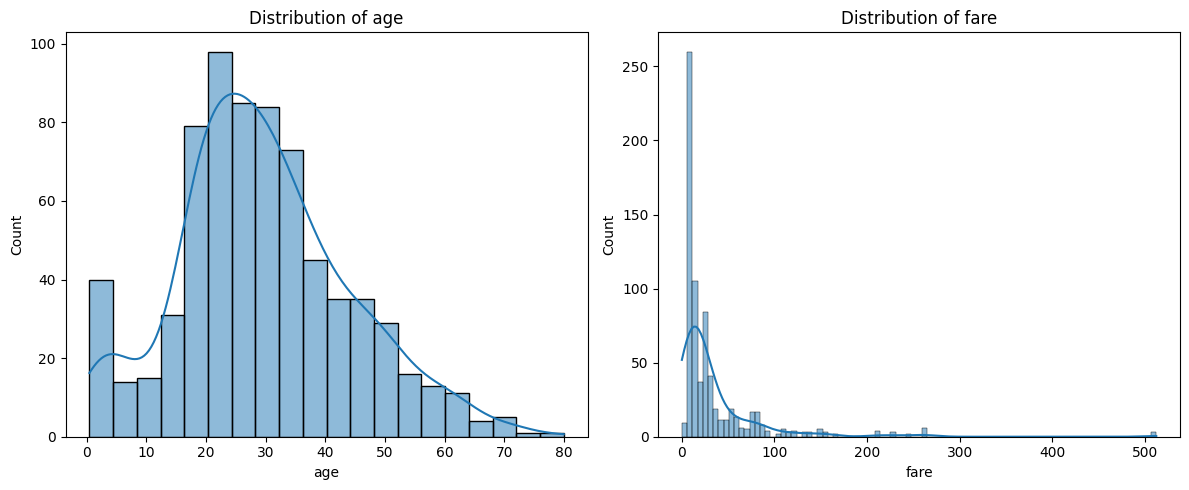

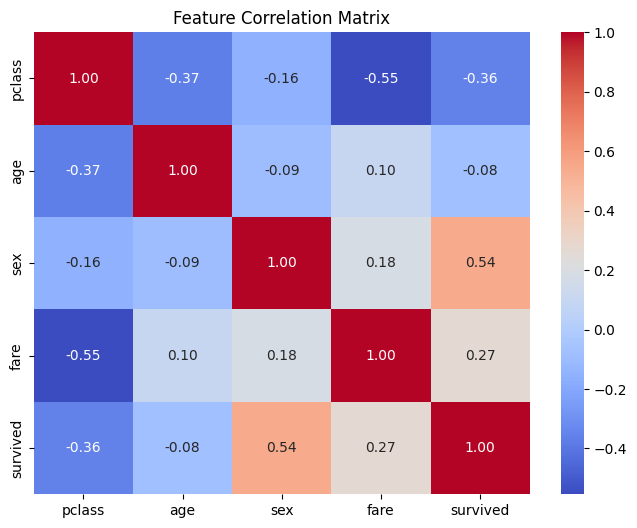

In [16]:
# EDA

# Dataset Overview
print("Dataset Shape:", data.shape)
print("First Few Rows of the Dataset:")
print(data.head())

# Check for Missing Values
print("\nMissing Values per Column:")
print(data.isnull().sum())

# Data Type Inspection
print("\nData Types:")
print(data.dtypes)

# Statistical Summary
print("\nStatistical Summary of Numerical Features:")
print(data.describe())

# Distribution of Numerical Features
numerical_features = ['age', 'fare']

plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

### Findings:
- The heatmap above shows that `fare` and `pclass` are negatively correlated (-0.55). This makes sense since passengers in higher classes generally paid higher fares.
- There is little to no correlation between `age` and other features, suggesting that `age` has more individual influence on survival.
- Since `pclass` and `fare` are correlated, we need to be cautious when interpreting the results from explainability techniques like PDP, which assume independence between features.
---

## Model Training

Now that we’ve preprocessed the data, we can proceed with training the model. For this analysis, we’ll use a Random Forest Classifier. This model is a good choice because it is a robust, non-linear classifier capable of capturing complex interactions between features. Additionally, Random Forest provides built-in feature importance scores, which will complement our explainability techniques.


In [17]:
# Train-Test Split
X = data.drop('survived', axis=1)
y = data['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
print("\nModel Score (Training):", model.score(X_train, y_train))
print("Model Score (Testing):", model.score(X_test, y_test))


Model Score (Training): 0.9912434325744308
Model Score (Testing): 0.7482517482517482


### Model Explanation:
- The Random Forest model trains multiple decision trees and aggregates their results, which helps reduce overfitting and gives a more generalized prediction.
- Since Random Forest models are relatively interpretable and can handle both categorical and continuous features well, they are ideal for analyzing tabular datasets like Titanic.
---

### Partial Dependence Plots (PDP) & Individual Conditional Expectation (ICE) Plots Implementation
PDPs show the marginal effect of features on model predictions. We'll examine how 'age' and 'fare' influence survival predictions while averaging other features' effects.

ICE plots extend PDPs by showing individual instance predictions. This helps identify heterogeneous effects that PDPs might mask through averaging.

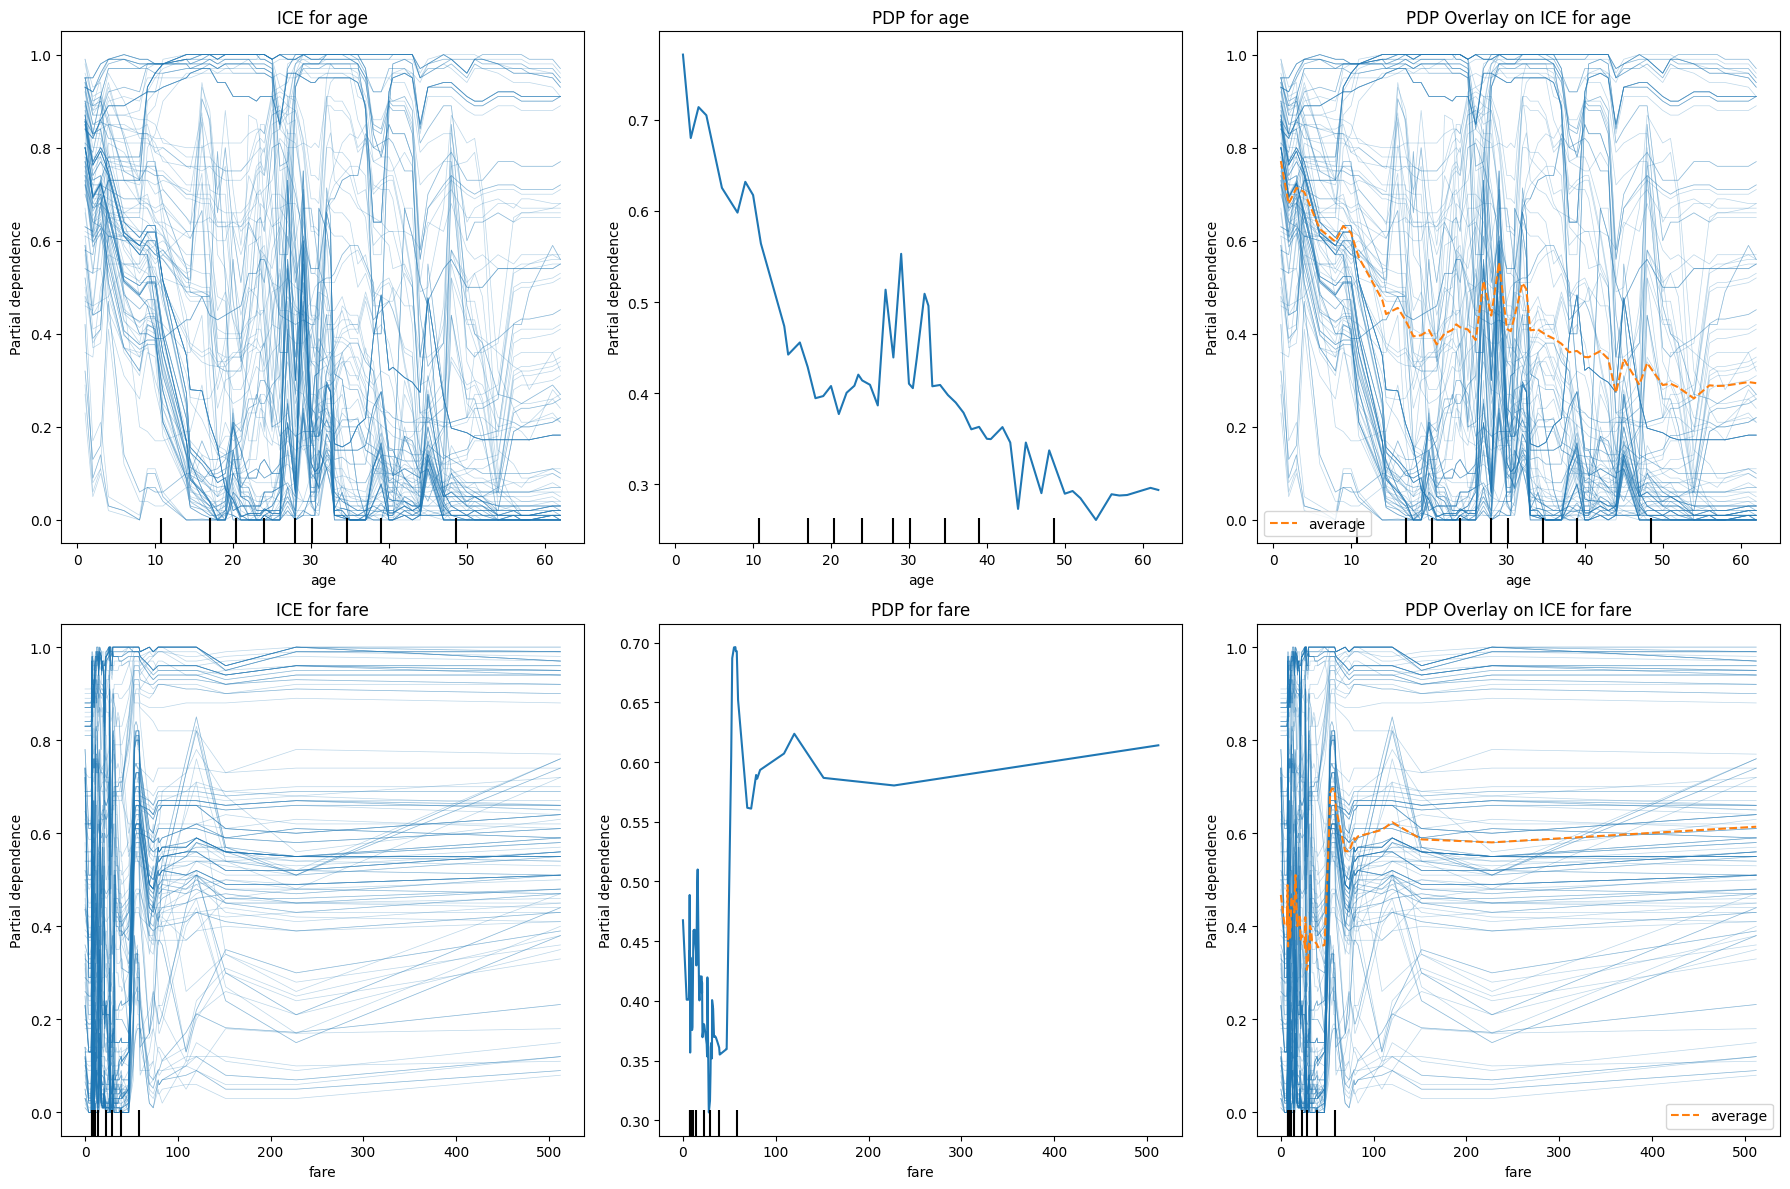

In [18]:
# Features to plot
features = ['age', 'fare']

# Create subplots for ICE, PDP, and Overlay
fig, axes = plt.subplots(len(features), 3, figsize=(18, 12))

for i, feature in enumerate(features):
    # ICE Plot
    ice_display = PartialDependenceDisplay.from_estimator(
        model, X_test, [feature], kind='individual', ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'ICE for {feature}')

    # PDP Plot
    pdp_display = PartialDependenceDisplay.from_estimator(
        model, X_test, [feature], kind='average', ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'PDP for {feature}')

    # Overlay PDP on ICE Plot
    # First, plot the ICE plot and capture axes_
    ice_pdp_display = PartialDependenceDisplay.from_estimator(
        model, X_test, [feature], kind='both', ax=axes[i, 2]  # 'both' combines PDP and ICE
    )
    axes[i, 2].set_title(f'PDP Overlay on ICE for {feature}')

# Adjust layout
plt.tight_layout()
plt.show()

#### Results Analysis - Age Effects
The PDP and ICE plots for age reveal complex patterns in survival probability:

1. **Overall Trend (PDP)**:
   - High survival probability (~0.7) for very young passengers
   - Sharp decline between ages 0-20
   - Gradual decrease from ages 20-50
   - Stabilization around 0.3 probability after age 50

2. **Individual Effects (ICE)**:
   - Significant variation between individual predictions
   - Multiple crossing lines indicating strong interaction effects
   - Most pronounced variations in 20-40 age range
   - Some individuals show opposite trends to the average

#### Results Analysis - Fare Effects
The fare analysis shows distinct patterns:

1. **Overall Trend (PDP)**:
   - Initial volatility in low fare range (0-50)
   - Sharp increase around fare value 100
   - Gradual stabilization in higher fare ranges
   - Positive correlation with survival probability

2. **Individual Effects (ICE)**:
   - More consistent patterns compared to age
   - Less crossing behavior suggesting fewer interactions
   - Clear stratification in higher fare ranges
   - Individual predictions align more closely with average trend

### First-Order ALE Analysis

---

### Accumulated Local Effects (ALE) Plots
ALE plots provide unbiased feature effect estimates, particularly useful for correlated features. We'll analyze both first-order and second-order effects.

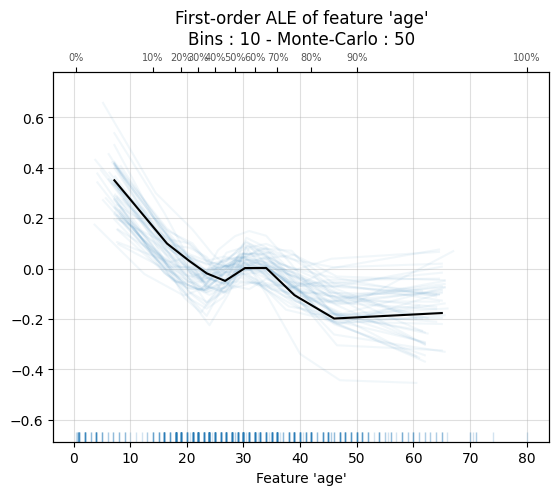

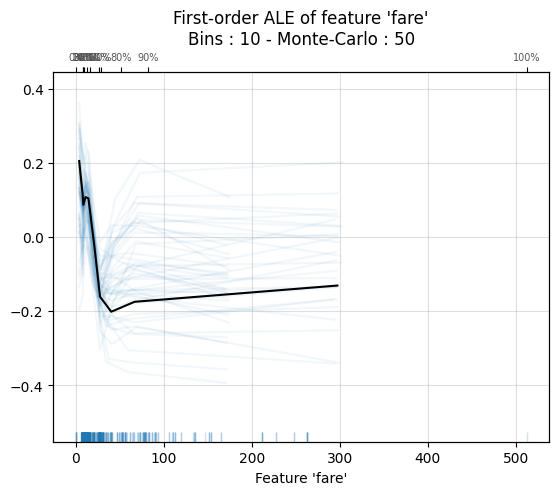

<Axes: title={'center': "First-order ALE of feature 'fare'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'fare'">

In [19]:
# First-order ALE Plot with default parameters for 'age' and 'fare'
ale_plot(
    model,
    X_train,
    "age",
    bins=10,
    monte_carlo=True,
    monte_carlo_rep=50,
    monte_carlo_ratio=1.0,
)

ale_plot(
    model,
    X_train,
    "fare",
    bins=10,
    monte_carlo=True,
    monte_carlo_rep=50,
    monte_carlo_ratio=1.0,
)

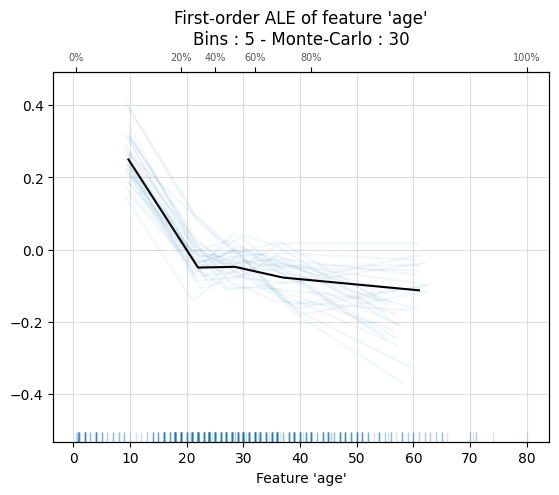

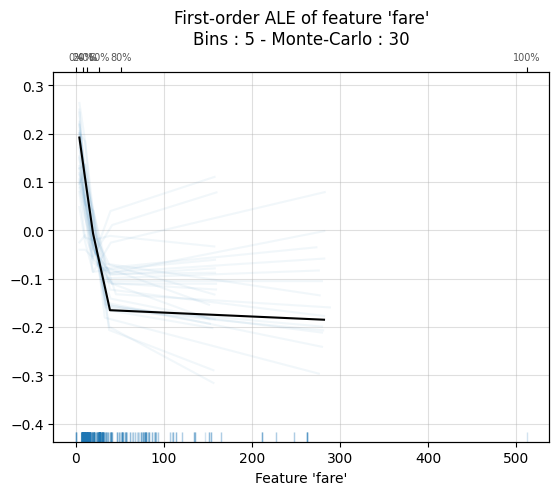

<Axes: title={'center': "First-order ALE of feature 'fare'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'fare'">

In [11]:
# First-order ALE Plot with custom parameters for 'age' and 'fare'
ale_plot(
    model,
    X_train,
    "age",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model,
    X_train,
    "fare",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

#### Results Analysis - First-Order ALE
The ALE plots provide unbiased feature effect estimates:

1. **Age ALE Effects**:
   - More conservative effect estimates compared to PDP
   - Clear negative trend with increasing age
   - Strongest effects in 0-20 age range
   - Confidence intervals widen with age

2. **Fare ALE Effects**:
   - Sharp initial positive effect
   - Quick stabilization after fare > 100
   - Narrower confidence intervals in lower ranges
   - More stable effects compared to age


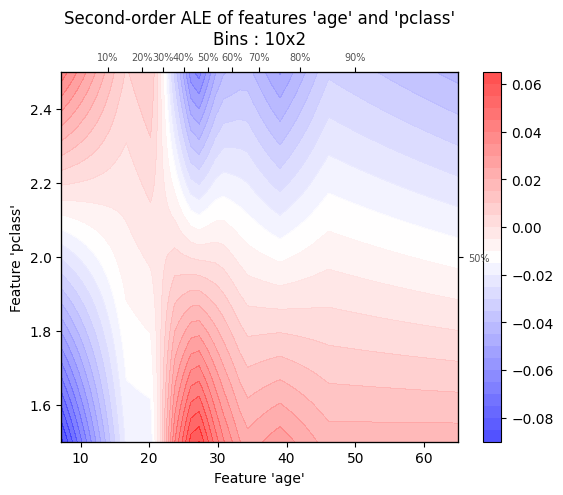

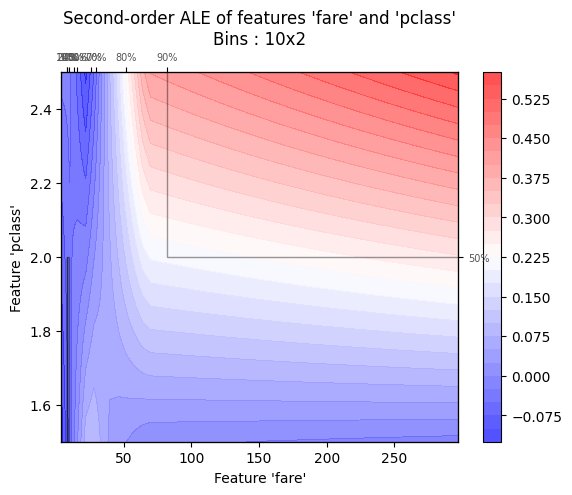

<Axes: title={'center': "Second-order ALE of features 'fare' and 'pclass'\nBins : 10x2"}, xlabel="Feature 'fare'", ylabel="Feature 'pclass'">

In [12]:
# 2D Second-Order ALE Plot for 'age' and 'fare'
ale_plot(model, X_train, ['age', 'pclass'], bins=[10, 4])
ale_plot(model, X_train, ['fare', 'pclass'], bins=[10, 4])

#### Results Analysis - Feature Interactions
The second-order ALE plots reveal important interaction patterns:

1. **Age-Class Interaction**:
   - Complex interaction structure
   - Strong negative effects for young, high-class passengers
   - Positive effects for middle-aged, lower-class passengers
   - Clear transition zones between effects

2. **Fare-Class Interaction**:
   - Strong structured relationship
   - Clear diagonal stratification
   - Positive effects for high fare-high class combination
   - Negative effects for low fare-low class combination

---

# Comparative Analysis

## 1. Method Comparison

### PDP vs ALE
1. **Estimation Differences**:
   - PDPs show larger effect ranges
   - ALE provides more conservative estimates
   - ALE better handles correlated features
   - PDPs may overestimate in sparse regions

2. **Interpretation Value**:
   - PDPs offer more intuitive interpretation
   - ALE provides more accurate local effects
   - Both methods complement each other
   - ALE superior for correlated features

### ICE vs Aggregated Methods
1. **Individual vs Average Effects**:
   - ICE reveals heterogeneity masked by PDPs
   - Individual patterns important for age
   - Less crucial for fare analysis
   - Helps identify potential subgroups

## 2. Feature Impact Comparison

### Age vs Fare
1. **Effect Stability**:
   - Fare shows more stable effects
   - Age effects more complex and varied
   - Fare better predictor in higher ranges
   - Age more important in younger ranges

2. **Interaction Strength**:
   - Age shows stronger interactions
   - Fare effects more independent
   - Class interaction stronger with fare
   - Age interactions more nuanced

## 3. Practical Implications

### Model Understanding
1. **Feature Importance**:
   - Fare more reliable predictor
   - Age effects need careful interpretation
   - Class interactions crucial
   - Combined effects strongest

2. **Prediction Confidence**:
   - Higher in well-defined fare ranges
   - Lower for age-based predictions
   - Strongest for fare-class combinations
   - Careful consideration needed for edge cases

---

## Key Takeaways

1. **Methodological Insights**:
   - Multiple methods needed for complete understanding
   - ALE provides most reliable estimates
   - ICE crucial for heterogeneity detection
   - Second-order effects significant

2. **Feature Understanding**:
   - Fare more predictable than age
   - Class interactions fundamental
   - Age effects vary significantly
   - Complex interaction structure